## Importing necessary libraries

In [1]:
# These are the libraries will be used for this project.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [2]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

<!--Empty Space for separating topics-->

<h2 id="data_class">Dataset Class</h2>

 This dataset class is defined here, tensors will be used instead of jpeg images.

In [3]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="/home/dsxuser/work"
        positive="Positive_tensors"
        negative='Negative_tensors'

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor transformation
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
               
        image=torch.load(self.all_files[idx])
        y=self.Y[idx]
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
    
print("done")

done


We create two dataset objects, one for the training data and one for the validation data.

In [ ]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)

<h2 id="Question_1">Question 1</h2>

WWe will use the pre-trained resnet18 model for this classification problem. \
<b>Preparing a pre-trained resnet18 model:</b>

<b>Step 1</b>: Loading the pre-trained model <code>resnet18</code> Setting the parameter <code>pretrained</code> to true:

In [9]:
# Step 1: Load the pre-trained model resnet18

model = models.resnet18( pretrained=True )

mean = [ 0.485, 0.456, 0.406 ] 
std = [ 0.229, 0.224, 0.225 ]

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/dsxuser/.cache/torch/checkpoints/resnet18-5c106cde.pth


<b>Step 2</b>: We set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.

In [10]:
# Step 2: Set the parameter cannot be trained for the pre-trained model
for param in model.parameters():
    param.requires_grad = False

<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs. 

<b>Step 3</b>: Replacing the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes. For the parameters <code>in_features </code>, the last hidden layer has 512 neurons.

In [11]:
model.fc = nn.Linear(512, 2)


Printing the model here to show the modification of resnet18 model:

In [12]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We will start training the model:

<b>Step 1</b>: Creating a cross entropy criterion function 

In [13]:
# Step 1: Create the loss function

criterion = nn.CrossEntropyLoss()

<b>Step 2</b>: Creating a training loader and validation loader object, the batch size has 100 samples each.

In [14]:
train_loader = DataLoader( dataset = train_dataset, batch_size=100 )

validation_loader = DataLoader( dataset = validation_dataset, batch_size=100 )

<b>Step 3</b>: Using the following optimizer to minimize the loss 

In [15]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

In [16]:
#Checking the shape of input
for x, y in train_loader:
    
    print(x[0].shape)
    break


torch.Size([3, 224, 224])


<!--Empty Space for separating topics-->

**Here I train the model for one epoch due to the training data size. Also, I calculate the accuracy on the validation data.**

In [17]:
n_epochs=1
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)
start_time = time.time()
n_epochs = 1

Loss=0
start_time = time.time()

for epoch in range(n_epochs):
    for x, y in train_loader:

        model.train() 
        
        #clearing gradient 
        optimizer.zero_grad()
        
        #makeing a prediction 
        yhat = model(x)
        
        # calculating loss 
        loss = criterion(yhat, y)
        
        # calculating gradients of parameters 
        loss.backward()
        
        # updating parameters 
        optimizer.step()
        
        loss_list.append(loss.data)
        
    correct=0
    
    for x_test, y_test in validation_loader:
        
        # setting model to eval 
        model.eval()
        
        #making a prediction 
        z = model(x_test)
        
        #finding max 
        _, yhat = torch.max(z.data, 1)
            
        #Counting correctly classified samples in mini-batch, and adding to the accumulator 
        correct += (yhat == y_test).sum().item()
   
    #Calculating accuracy
    accuracy=correct/N_test



<b>Below, I print out the accuracy. The accuracy is 99.51%</b>

In [18]:
accuracy

0.9951

**Plotting how the loss function decreased across iterations.**

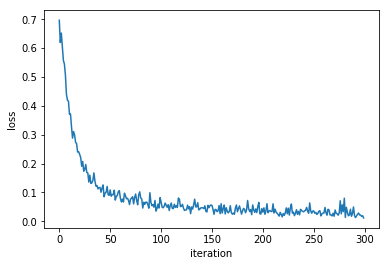

In [19]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


<b>Identifying the first four misclassified samples using the validation data:</b>

In [22]:
mis_counter = 0

loop_counter = 0

batch_size = 100

mis_idx_list = []

yhat_all = []
y_test_all = []

for x_test, y_test in validation_loader:
    
    model.eval()
    z = model(x_test)
    _, yhat = torch.max(z.data, 1)
    yhat_all.append(yhat)
    y_test_all.append(y_test)
    for i in range( len(yhat) ):
        if yhat[i] != y_test[i]:
            mis_counter += 1
            mis_idx_list.append(loop_counter*batch_size+i)
            print("{}th misclassified image index: {}".format(mis_counter, loop_counter*batch_size+i))
            if mis_counter == 4:
                break
    loop_counter += 1

1th misclassified image index: 143
2th misclassified image index: 165
3th misclassified image index: 678
4th misclassified image index: 946
5th misclassified image index: 1240
6th misclassified image index: 1306
7th misclassified image index: 1336
8th misclassified image index: 1445
9th misclassified image index: 1775
10th misclassified image index: 1986
11th misclassified image index: 1998
12th misclassified image index: 2721
13th misclassified image index: 3094
14th misclassified image index: 3422
15th misclassified image index: 3832
16th misclassified image index: 3996
17th misclassified image index: 4450
18th misclassified image index: 4628
19th misclassified image index: 4769
20th misclassified image index: 5309
21th misclassified image index: 5358
22th misclassified image index: 5655
23th misclassified image index: 5712
24th misclassified image index: 5822
25th misclassified image index: 5878
26th misclassified image index: 6212
27th misclassified image index: 6244
28th misclassi

**Model missclassified for the image indexes: 143, 165, 678, 946**

In [93]:
mis_list1 = [143, 165, 678, 946]

for i in range(len(mis_list1)):
    print("Sample {} (index starts from 0) predicted value: {} actual value: {}".format( mis_list1[i], yhat_all[mis_list1[i]//100][mis_list1[i]%100], y_test_all[mis_list1[i]//100][mis_list1[i]%100] ))

Sample 143 (index starts from 0) predicted value: 1 actual value: 0
Sample 165 (index starts from 0) predicted value: 1 actual value: 0
Sample 678 (index starts from 0) predicted value: 0 actual value: 1
Sample 946 (index starts from 0) predicted value: 0 actual value: 1


**In the following concrete image, model classified it as a cracked concrete. However, the concrete in this image was not cracked. But we can see that the texture of this concrete image can misguide the model easily.**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


yhat: 1
y: 0


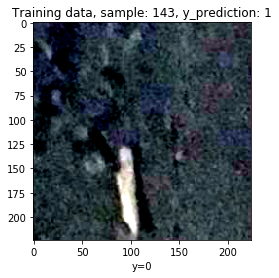

In [65]:
print("yhat: {}".format(yhat_all[1][43]))
print("y: {}".format(y_test_all[1][43]))

plt.imshow(validation_dataset[143][0].permute(1, 2, 0))
plt.xlabel("y="+str(validation_dataset[143][1].item()))
plt.title("Training data, sample: {}, y_prediction: {}".format(int(143), yhat_all[1][43]))
plt.show()

**In the following concrete image also, model classified it as a cracked concrete even though the concrete in this image was not cracked. The texture of this concrete image is not clear, and the model can be misguided easily.**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


yhat: 1
y: 0


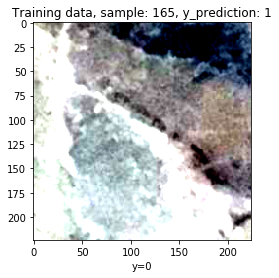

In [64]:
print("yhat: {}".format(yhat_all[1][65]))
print("y: {}".format(y_test_all[1][65]))

plt.imshow(validation_dataset[165][0].permute(1, 2, 0))
plt.xlabel("y="+str(validation_dataset[165][1].item()))
plt.title("Training data, sample: {}, y_prediction: {}".format(int(165), yhat_all[1][65]))
plt.show()

**For this next concrete image, model classified it as a non-cracked concrete although the concrete in this image was cracked. The crack in concrete was small. Therefore, the model was not able to capture it.**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


yhat: 0
y: 1


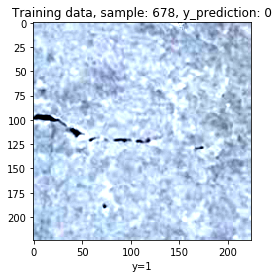

In [66]:
print("yhat: {}".format(yhat_all[6][78]))
print("y: {}".format(y_test_all[6][78]))

plt.imshow(validation_dataset[678][0].permute(1, 2, 0))
plt.xlabel("y="+str(validation_dataset[678][1].item()))
plt.title("Training data, sample: {}, y_prediction: {}".format(int(678), yhat_all[6][78]))
plt.show()

**In the below case, also model classified it as a non-cracked concrete. However, the concrete in this image was cracked. The crack in concrete was very wide in the middle. Hence, the model might have judged this crack as the texture of concrete, not crack.**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


yhat: 0
y: 1


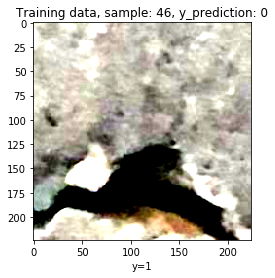

In [72]:
print("yhat: {}".format(yhat_all[9][46]))
print("y: {}".format(y_test_all[9][46]))

plt.imshow(validation_dataset[946][0].permute(1, 2, 0))
plt.xlabel("y="+str(validation_dataset[946][1].item()))
plt.title("Training data, sample: {}, y_prediction: {}".format(int(46), yhat_all[9][46]))
plt.show()

**Below, I plot some examples where the model correctly classified the concrete images as cracked.**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


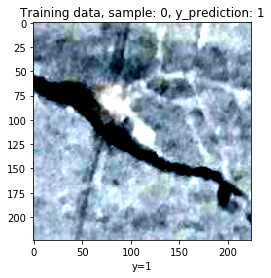

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


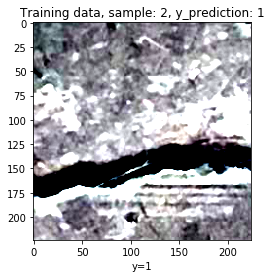

In [74]:
plt.imshow(validation_dataset[0][0].permute(1, 2, 0))
plt.xlabel("y="+str(validation_dataset[0][1].item()))
plt.title("Training data, sample: {}, y_prediction: {}".format(int(0), yhat_all[0][0]))
plt.show()

plt.imshow(validation_dataset[2][0].permute(1, 2, 0))
plt.xlabel("y="+str(validation_dataset[2][1].item()))
plt.title("Training data, sample: {}, y_prediction: {}".format(int(2), yhat_all[0][2]))
plt.show()

**Finally, I display some examples where the model correctly classified the concrete images as non-cracked.**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


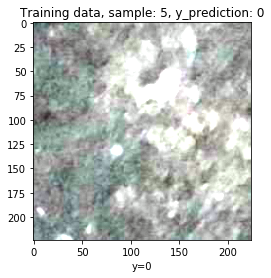

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


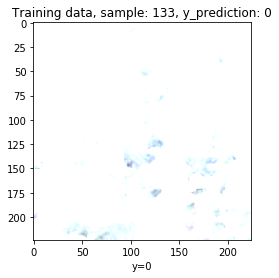

In [86]:
plt.imshow(validation_dataset[5][0].permute(1, 2, 0))
plt.xlabel("y="+str(validation_dataset[5][1].item()))
plt.title("Training data, sample: {}, y_prediction: {}".format(int(5), yhat_all[0][5]))
plt.show()

plt.imshow(validation_dataset[133][0].permute(1, 2, 0))
plt.xlabel("y="+str(validation_dataset[133][1].item()))
plt.title("Training data, sample: {}, y_prediction: {}".format(int(133), yhat_all[1][33]))
plt.show()